# Superstore (Parte II): análise RFM com Python

A análise RFM é uma técnica de segmentação de clientes usada para entender o comportamento de compra de um público e, assim, otimizar estratégias de marketing e vendas. A análise é baseada em três critérios:
- **Recência (R)**: Mede o tempo desde a última compra de um cliente. Quanto mais recente a compra, mais provável é que o cliente esteja interessado em continuar comprando.
- **Frequência (F)**: Avalia com que frequência o cliente realiza compras em determinado período. Clientes que compram com mais frequência são considerados mais engajados.
- **Valor Monetário (M)**: Refere-se ao valor total gasto pelo cliente em um período de tempo. Clientes que gastam mais são frequentemente considerados mais valiosos para a empresa.

Este documento é a segunda parte de um exercício prático que envolve a análise exploratória de dados e a investigação de perguntas de negócio utilizando a linguagem Python como principal ferramenta. Para tal fim, foi utilizado um _dataset_ público da Superstore, obtido por meio plataforma Kaggle.

Maiores explicações a respeito da importação dos dados, limpeza e _sanity checks_ podem ser encontradas na primeira parte da análise!

## 0. Importando bibliotecas 📔

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns

import datetime
import time
from datetime import date
from datetime import datetime, date, time

%matplotlib inline

from functools import reduce

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Colocando estilo nos gráficos
plt.style.use('seaborn-v0_8-whitegrid')

## 1. Importando os dados 🎲

In [4]:
# Abrindo o arquivo
data_source=pd.read_csv('superstore.csv', encoding='ISO-8859-1')

In [5]:
# Fazendo cópia para edição
data=data_source.copy()

## 2. Explorando os dados 🔍

In [8]:
# Lembrando quais colunas temos
data.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

In [9]:
# Lembrando em que formato estão os dados
data.dtypes

Row ID             int64
Order ID          object
Order Date        object
Ship Date         object
Ship Mode         object
Customer ID       object
Customer Name     object
Segment           object
Country           object
City              object
State             object
Postal Code        int64
Region            object
Product ID        object
Category          object
Sub-Category      object
Product Name      object
Sales            float64
Quantity           int64
Discount         float64
Profit           float64
dtype: object

## 3. Limpando os dados 🧹

In [10]:
# Eliminando a coluna Row ID
data.drop('Row ID', axis=1, inplace=True)

In [11]:
# Fazendo uma nova coluna de mês do pedido
data['order_month']=pd.to_datetime(data ['Order Date']).dt.to_period('m')

In [45]:
# Fazendo uma nova coluna de ano do pedido
data['order_year']=pd.to_datetime(data['Order Date']).dt.to_period('y')

## 4. Encontrando nossos clientes lucrativos 💰

Iremos começar a análise com algumas explorações iniciais.


Primeiramente, vamos criar uma tabela para descobrir qual é o valor total de lucro que cada um dos clientes trouxe à empresa.

In [15]:
data.groupby('Customer Name')['Profit'].sum().sort_values(ascending=False).head(10)

Customer Name
Tamara Chand            8981.3239
Raymond Buch            6976.0959
Sanjit Chand            5757.4119
Hunter Lopez            5622.4292
Adrian Barton           5444.8055
Tom Ashbrook            4703.7883
Christopher Martinez    3899.8904
Keith Dawkins           3038.6254
Andy Reiter             2884.6208
Daniel Raglin           2869.0760
Name: Profit, dtype: float64

Em seguida, vamos contar o número de clientes a partir do _Customer ID_, que é único. Podemos utilizar a função `unique`, que gera um _array_, e a função `len`, que nos informa o comprimento do _array_.

In [17]:
len(data['Customer ID'].unique())

793

#### **Análise de pareto**

Essa tática pode ser utilizada para checar se nossos top clientes são responsáveis por uma parcela muito significativa do lucro total da empresa. Se a resposta for sim, esse grupo deverá ser tratado com muito cuidado: quanto maior a porcentagem de participação no valor, maior a nossa relação de dependência com um número muito pequeno de pessoas.

Vamos nomear a nossa tabela de lucro total por cliente:

In [23]:
lucro_clientes=data.groupby('Customer Name')['Profit'].sum().sort_values(ascending=False)

O próximo passo é descobrir o lucro mínimo de nosso top 25% clientes.
Ou seja, nessa tabela ordenada, queremos todos os clientes que estão _acima_ dos outros 75%.

In [22]:
lucro_clientes.quantile(0.75)

560.0078

Isso significa que o quartil de clientes mais lucrativos corresponde a todas as pessoas que obtiveram lucro maior ou igual a 560. Precisamos filtrar este grupo em uma nova tabela.

In [24]:
top_clientes=lucro_clientes[lucro_clientes>lucro_clientes.quantile(0.75)]

Para saber qual a proporção de sua participação em relação ao lucro total, vamos descobrir quanto de lucro esse top 25% gera para a nossa empresa.

In [31]:
lucro_top_clientes=top_clientes.sum()
lucro_top_clientes/data['Profit'].sum()

0.9002756343956773

Isso significa que **mais de 90%** dos lucros totais da empresa estão concentrados na mão dos top 25% clientes.
Não podemos perder essas pessoas, já que nossa lucratividade é altamente dependente delas! Sugestões: podemos investir em mimos para reter os top clientes, ao passo que aplicamos estratégias de marketing com o intuito de captar novas bases.

#### **Normalizando o lucro dos clientes pelo tempo**

Um cliente pode ser lucrativo por diversas razões: pela alta quantidade de compras, pelo alto valor de compras ou por possuir mais "tempo de casa". Dessa maneira, para construirmos um verdadeiro ranking de top clientes, devemos considerar há quanto tempo cada pessoa permanece na base.

Primeiramente, vamos entender como encontrar a diferença de tempo entre a primeira compra do cliente e o 'fechamento' da empresa.

- Precisamos descobrir a data da primeira compra e a data do fechamento;
- Calcular a diferença entre a data da primeira compra e a data do fechamento;
- Agrupar por cliente qual foi a maior diferença entre data de compra e fechamento: essa é a quantidade de meses que meu cliente ficou na base.

Antes de puxarmos os dados para cumprir o primeiro passo, é necessário converter as datas do formato texto para o formato data (_string to datetime_).
Podemos utilizar a função com parâmetros indicando a coluna onde está o texto a ser transformado e o formato que desejamos: `datetime.strptime(data['Order Date'], '%m/%d/%Y'`.

A função acima exige que informemos os dados linha a linha. Para automatizar o processo, recorreremos ao `lambda`, uma forma mais simplificada do `def`.
Junto ao `lambda`, adicionamos o `apply`, de forma que todos os dados de uma mesma coluna serão afetados pela função.

**Passo 01**: descobrindo a data da primeira compra e a data do fechamento.

Data do fechamento da empresa:

In [33]:
data_ultima_compra=data['Order Date'].apply(lambda x: datetime.strptime(x, '%m/%d/%Y')).max()
print(data_ultima_compra)

2017-12-30 00:00:00


Coluna com as datas dos pedidos:

In [34]:
data['data_pedido']=data['Order Date'].apply(lambda x: datetime.strptime(x, '%m/%d/%Y'))

**Passo 02**: calculando a diferença entre a data da compra e a data do fechamento.

A ideia é que criemos uma coluna contendo, para cada cliente, o intervalo de dias entre a primeira compra e o fechamento. Vamos utilizar a função `def` para calcular essa diferença e a função `apply` para que todos os resultados obtenham retorno. 

In [46]:
def date_difference (coluna):
    date_difference=data_ultima_compra-coluna
    return date_difference

data['diff_ultima_compra_dias']=data['data_pedido'].apply(lambda x:date_difference(x))

Posteriormente, vamos dividir o lucro de cada cliente pela quantidade de dias na base. Note que o valor do lucro está no formato número inteiro e o intervalo de dias é printado na tabela como "_N days_". Para “apagar” o texto _days_ e operar a conta, vamos incluir `dt.days` no nosso código.

In [47]:
data['diff_ultima_compra_dias']=data['data_pedido'].apply(lambda x:date_difference(x)).dt.days

Também podemos criar uma coluna de intervalo de meses dividindo o número de dias por 30.
Faremos o arredondamento para cima, de forma que não tenhamos meses quebrados (arredondar para cima é uma decisão mais conservadora).
Vamos usar o `apply` para aplicar a função `ceil`.

In [48]:
data['diff_ultima_compra_meses']=(data['diff_ultima_compra_dias']/30).apply(lambda x: math.ceil(x))

Observe como ficou a tabela com nossas novas colunas:

In [49]:
data.head(5)

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,...,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,order_month,data_pedido,diff_ultima_compra_dias,diff_ultima_compra_meses
0,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,...,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136,2016-11,2016-11-08,417,14
1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,...,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820,2016-11,2016-11-08,417,14
2,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,...,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714,2016-06,2016-06-12,566,19
3,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,...,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310,2015-10,2015-10-11,811,28
4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,...,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164,2015-10,2015-10-11,811,28


**Passo 03**: calculando o número de meses que o usuário permaneceu na base.

Vamos começar agrupando por cliente a maior diferença entre data de compra e fechamento.

In [56]:
tempo_vida_clientes=data.groupby('Customer Name')['diff_ultima_compra_meses'].max()
lucro_por_mes=lucro_clientes/tempo_vida_clientes

Dessa forma, obtivemos a quantidade de **lucro por mês** de cada cliente. Podemos ainda organizar a lista por valores.

In [57]:
lucro_por_mes.sort_values(ascending=False).head(15)

Customer Name
Raymond Buch            317.095268
Tamara Chand            230.290356
Adrian Barton           147.156905
Sanjit Chand            119.946081
Hunter Lopez            117.133942
Christina DeMoss        116.513700
Tom Ashbrook            114.726544
Christopher Martinez    114.702659
Christopher Conant      108.852465
Jenna Caffey             83.820733
Helen Wasserman          77.291468
Keith Dawkins            75.965635
Andy Reiter              75.911074
Adam Bellavance          73.378161
Theresa Coyne            66.383300
dtype: float64

Essa é a nossa **relação mais confiável de clientes**, pois foi normalizada através do tempo.

## 5. Análise RFM 💻

Análise RFM é uma análise de Recência, Frequência e valor Monetário. Para realizá-la, é necessário agrupar os dados dos clientes a partir de cada uma destas variáveis.
Cada variável recebe uma designação de 1 a 5, sendo 1 o pior e 5 o melhor.

A melhor forma de fazer isso é por meio de uma tabela contendo:
- Customer ID;
- Data da primeira compra;
- Data da última compra;
- Frequência de compra;
- Valor monetário.

#### Parte 1: criando nossa tabela

Vamos começar a desenvolver nossa tabela base.
O primeiro passo será a **coluna de frequência**, onde podemos agrupar a quantidade de pedidos por Customer ID.
Na verdade, faremos **primeiro** um agrupamento duplo de Customer ID e Order ID, de forma que as ordens de pedidos não sejam contabilizadas mais de uma vez.

Usando `reset_index()`, garantimos que Customer ID e Order ID apareçam como colunas normais.

In [60]:
data.groupby(['Customer ID', 'Order ID']).count().reset_index()[['Customer ID', 'Order ID']]

,Customer ID,Order ID
0,AA-10315,CA-2014-128055
1,AA-10315,CA-2014-138100
2,AA-10315,CA-2015-121391
3,AA-10315,CA-2016-103982
4,AA-10315,CA-2017-147039
...,...,...
5004,ZD-21925,CA-2014-143336
5005,ZD-21925,CA-2016-152471
5006,ZD-21925,CA-2016-167682
5007,ZD-21925,CA-2017-141481


Agora sim, podemos realizar um novo agrupamento para a quantidade de pedidos por cliente.

In [62]:
pedidos=data.groupby(['Customer ID', 'Order ID']).count().reset_index()[['Customer ID', 'Order ID']].groupby('Customer ID')['Order ID'].count().reset_index()

Pronto! **Agrupamos cada cliente por sua quantidade de pedidos (F)**.

Partiremos para o próximo passo, o **lucro por cliente**.
Calculamos o lucro por cliente anteriormente, mas não podemos utilizar aquela tabela: não é possível fazer a junção de nenhuma de suas colunas com as colunas da tabela de frequência, visto que a primeira não possui Customer ID.
Vamos criar uma nova!

In [64]:
lucro_clientes_customerid=data.groupby('Customer ID')['Profit'].sum().reset_index()

Agora temos uma tabela com a **contribuição monetária de cada cliente (M)**. As nossas duas tabelas (F e M) possuem colunas iguais (Customer ID).

O próximo passo consiste em extrair os **dados da recência**, ou seja, vamos descobrir a diferença entre a data da primeira e a última compra. Lembrando que já havíamos transformado os dados que eram _string_ em formato data (a nossa coluna _data_pedido_).

Mais uma vez, o agrupamento será realizado por Customer ID.

In [65]:
primeira_compra=data.groupby('Customer ID')['data_pedido'].min()
ultima_compra=data.groupby('Customer ID')['data_pedido'].max()

Temos quatro tabelas:
- Frequência (_pedidos_);
- Valor monetário (_lucro_clientes_customerid_);
- Primeira compra (_primeira_compra_);
- Última compra (_ultima_compra_).

Todas as tabelas possuem uma coluna em comum: **Customer ID**.
Vamos juntá-las utilizando uma função chamada `reduce`, com a qual podemos rodar uma função em específico aplicada consecutivamente a um conjunto de valores em uma lista.

Exemplo: `soma=reduce((lambda x, y: x+y), [1, 2, 3, 4])`.
- Além de indicar a função de soma, indicamos uma lista de valores;
- Dessa forma, teremos o retorno de todos os itens da lista somados: 1 + 2 + 3 + 4;
- É chamada `reduce` pois gera um único output (resultado).

Dentro da função reduce, vamos usar o `merge` para juntar as tabelas. Precisamos indicar a tabela, o tipo de join e a chave.

In [66]:
lista_de_tabelas=[primeira_compra, ultima_compra, pedidos, lucro_clientes_customerid]
tabelao=reduce((lambda left, right: pd.merge(left, right, on=['Customer ID'] )), lista_de_tabelas)

In [196]:
tabelao

,Customer ID,data_pedido_x,data_pedido_y,Order ID,Profit
0,AA-10315,2014-03-31,2017-06-29,5,-362.8825
1,AA-10375,2014-04-21,2017-12-11,9,277.3824
2,AA-10480,2014-05-04,2017-04-15,4,435.8274
3,AA-10645,2014-06-22,2017-11-05,6,857.8033
4,AB-10015,2014-02-18,2016-11-10,3,129.3465
...,...,...,...,...,...
788,XP-21865,2014-01-20,2017-11-17,11,621.2300
789,YC-21895,2014-11-17,2017-12-26,5,1305.6290
790,YS-21880,2015-01-12,2017-12-21,8,1778.2923
791,ZC-21910,2014-10-13,2017-11-06,13,-1032.1490


Aqui, temos a mesma situação previamente descrita: sem a normalização dos clientes no tempo, não sabemos se a lucratividade dos usuários é advinda de sua qualidade como comprador ou se é pelo fato de ser um cliente mais antigo na base.

Faremos algumas modificações na tabela para incorporar a variação do tempo:

- Dividiremos o lucro pela quantidade de meses que o cliente está na base;
- Dividiremos a quantidade de compras pela quantidade de meses que o cliente está na base.

A recência da compra pode ser encontrada comparando a data de última compra em relação ao fechamento: o melhor cliente é o que possui a menor diferença possível.
Podemos reaproveitar o dado que já foi calculado (coluna _diff_ultima_compra_meses_) e fazer o agrupamento por Customer ID, de forma que seja possível unir à outra tabela.

In [67]:
recencia=data.groupby('Customer ID')['diff_ultima_compra_meses'].min().reset_index()
tabelao_com_recencia=tabelao.merge(recencia, on='Customer ID')

O lucro por tempo será calculado dividindo o lucro de cada cliente pela diferença **máxima** de meses entre compra final e o fechamento (tempo do cliente na base, semelhante ao calculado acima).

Primero faremos a tabela de tempo na base.
Depois vamos juntar (`merge`) com o "tabelão".

In [68]:
tabela_tempo_na_base=data.groupby('Customer ID')['diff_ultima_compra_meses'].max().reset_index()
tabelao_com_diff=tabelao_com_recencia.merge(tabela_tempo_na_base, on='Customer ID')

tabelao_com_diff.head()

,Customer ID,data_pedido_x,data_pedido_y,Order ID,Profit,diff_ultima_compra_meses_x,diff_ultima_compra_meses_y
0,AA-10315,2014-03-31,2017-06-29,5,-362.8825,7,46
1,AA-10375,2014-04-21,2017-12-11,9,277.3824,1,45
2,AA-10480,2014-05-04,2017-04-15,4,435.8274,9,45
3,AA-10645,2014-06-22,2017-11-05,6,857.8033,2,43
4,AB-10015,2014-02-18,2016-11-10,3,129.3465,14,48


Com essa informação, podemos realizar a divisão do lucro e da quantidade de pedidos pela quantidade de meses na base.
Para os resultados, criaremos colunas novas!

In [69]:
tabelao_com_diff['Profit_per_month']=tabelao_com_diff['Profit']/tabelao_com_diff['diff_ultima_compra_meses_y']
tabelao_com_diff['frequencia_lifetime']=tabelao_com_diff['Order ID']/tabelao_com_diff['diff_ultima_compra_meses_y']

tabelao_com_diff.head()

,Customer ID,data_pedido_x,data_pedido_y,Order ID,Profit,diff_ultima_compra_meses_x,diff_ultima_compra_meses_y,Profit_per_month,frequencia_lifetime
0,AA-10315,2014-03-31,2017-06-29,5,-362.8825,7,46,-7.888750,0.108696
1,AA-10375,2014-04-21,2017-12-11,9,277.3824,1,45,6.164053,0.200000
2,AA-10480,2014-05-04,2017-04-15,4,435.8274,9,45,9.685053,0.088889
3,AA-10645,2014-06-22,2017-11-05,6,857.8033,2,43,19.948914,0.139535
4,AB-10015,2014-02-18,2016-11-10,3,129.3465,14,48,2.694719,0.062500


Nossa tabela está pronta para a análise RFM! Vamos começar?

#### Parte 2: desenvolvendo a análise

Trabalharemos com um sistema de pontuações que consiste em dividir a lista de cada variável em cinco partes, estabelecendo valores de 1 a 5 para cada uma das frações. Para separar os nossos quantis, utilizaremos a função `qcut`.

Faremos uma coluna para o R, uma para o F e uma para o M.

A coluna do R será um pouco diferente, porque a ordem de classificação é invertida - quanto menor a recência, melhor. A lista dos _labels_ de classificação em ordem _decrescente_ deve conter um parâmetro de identificação mostrando de quanto é a diminuição do _label_ entre um quantil e outro: no caso, -1, pois diminuímos a contagem de 1 em 1.

In [70]:
f_labels=range(1, 6)
m_labels=range(1, 6)
r_labels=list(range(5, 0, -1))

f_quartiles=pd.qcut(tabelao_com_diff['frequencia_lifetime'], 5, labels=f_labels)
m_quartiles=pd.qcut(tabelao_com_diff['Profit_per_month'], 5, labels=m_labels)
r_quartiles=pd.qcut(tabelao_com_diff['diff_ultima_compra_meses_y'], 5, labels=r_labels)

Agora vamos atribuir os valores dos quartis para as tabelas usando a função `assign`. Também designaremos nomes para as colunas (R, F, M).

In [72]:
tabelao_com_diff=tabelao_com_diff.assign(R=r_quartiles, F=f_quartiles, M=m_quartiles)

In [73]:
tabelao_com_diff.head()

,Customer ID,data_pedido_x,data_pedido_y,Order ID,Profit,diff_ultima_compra_meses_x,diff_ultima_compra_meses_y,Profit_per_month,frequencia_lifetime,R,F,M
0,AA-10315,2014-03-31,2017-06-29,5,-362.8825,7,46,-7.888750,0.108696,1,2,1
1,AA-10375,2014-04-21,2017-12-11,9,277.3824,1,45,6.164053,0.200000,2,4,3
2,AA-10480,2014-05-04,2017-04-15,4,435.8274,9,45,9.685053,0.088889,2,1,4
3,AA-10645,2014-06-22,2017-11-05,6,857.8033,2,43,19.948914,0.139535,2,2,5
4,AB-10015,2014-02-18,2016-11-10,3,129.3465,14,48,2.694719,0.062500,1,1,2


Temos uma tabela com as qualificações de R, F e M estabelecidas para cada cliente. 

Diferentes **combinações de valores** contém significados distintos.
Utilizaremos esta combinações para segmentar os usuários em nossa base: 

In [75]:
segt_map = {
    r'[1-2][1-2]':'Hibernando',
    r'[1-2][3-4]': 'Em risco',
    r'[1-2]5': 'Não pode perder',
    r'3[1-2]': 'Vai hibernar',
    r'33': 'Atenção requerida',
    r'[3-4][4-5]': 'Clientes fieis',
    r'41':'Promissor',
    r'51': 'Novos clientes',
    r'[4-5][2-3]': 'Potenciais fieis',
    r'5[4-5]': 'Champions'
}

Para finalizar, criaremos mais uma coluna para qualificar os nossos clientes de acordo com a segmentação acima. Entre as aspas, inserimos os valores de R e F.
Depois vamos usar nosso dicionário para substituir as legendas (função `replace`) utilizando lógica de `regex`.

In [76]:
tabelao_com_diff['Segment'] = tabelao_com_diff['R'].astype(str) + tabelao_com_diff['F'].astype(str)
tabelao_com_diff['Segment'] = tabelao_com_diff['Segment'].replace(segt_map, regex=True)

#### Confira o resultado final

In [213]:
tabelao_com_diff.head()

,Customer ID,data_pedido_x,data_pedido_y,Order ID,Profit,diff_ultima_compra_meses_x,diff_ultima_compra_meses_y,Profit_per_month,frequencia_lifetime,R,F,M,Segment
0,AA-10315,2014-03-31,2017-06-29,5,-362.8825,7,46,-7.888750,0.108696,1,2,1,Hibernando
1,AA-10375,2014-04-21,2017-12-11,9,277.3824,1,45,6.164053,0.200000,2,4,3,Em risco
2,AA-10480,2014-05-04,2017-04-15,4,435.8274,9,45,9.685053,0.088889,2,1,4,Hibernando
3,AA-10645,2014-06-22,2017-11-05,6,857.8033,2,43,19.948914,0.139535,2,2,5,Hibernando
4,AB-10015,2014-02-18,2016-11-10,3,129.3465,14,48,2.694719,0.062500,1,1,2,Hibernando


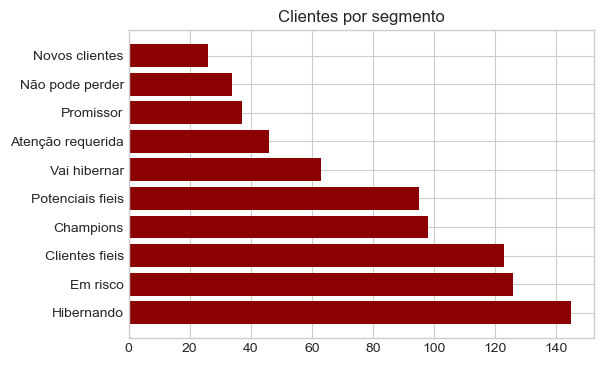

In [95]:
segmentos=tabelao_com_diff.groupby('Segment')['Customer ID'].count().sort_values(ascending=False)
plt.figure(figsize=(6,4))
plt.barh(segmentos.index, segmentos.values, color='darkred')
plt.title('Clientes por segmento')
plt.show()

#### Considerações

Um dos principais benefícios da postura _data-driven_ é a possibilidade de orientar estratégias de marketing de forma mais precisa e personalizada. Com uma análise detalhada sobre o comportamento do consumidor, preferências e segmentação de mercado, podemos desenvolver campanhas de marketing mais assertivas, que atingem diretamente o público-alvo e geram um retorno mais significativo sobre o investimento.